In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor,RandomForestClassifier
from sklearn.model_selection import cross_val_score
%matplotlib inline


data_train = pd.read_csv('train.csv')
data_test = pd.read_csv('test.csv')
print(data_train.info())  # 查看是否有缺失值
print(data_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pcl

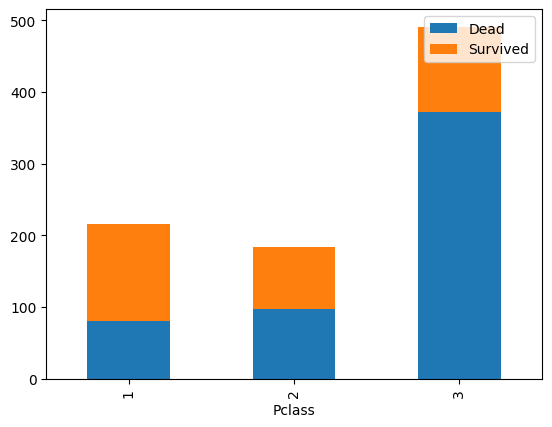

In [2]:
data_train.groupby(['Pclass', 'Survived'])['Survived'].count().unstack().plot(kind='bar', stacked=True)
plt.legend(['Dead', 'Survived'], loc='upper right')
plt.show()

下边一步我们来查看年龄对分类的影响，Age特征有一些缺失值，我们可以采用直接进行删除，也可以采用随机填补，或者使用线性回归来进行预测，我们暂时不明确哪一个方式填补完毕之后效果更好，而且Age又是一个连续值，它不能直接采用信息增益进行计算

In [3]:
data_train['Sex'] = data_train['Sex'].map({'male': 1, 'female': 0})
data_test['Sex'] = data_test['Sex'].map({'male': 1, 'female': 0})

In [4]:
train_delete = data_train.dropna(subset='Age')

利用线性回归来预测缺失值

In [5]:
# 选取需要的特征和标签
features = ['Pclass', 'Sex', 'SibSp', 'Parch']
label = 'Age'

# 训练线性回归模型，并预测缺失值
model = LinearRegression()
model.fit(train_delete[features], train_delete[label])
predicted_age = model.predict(data_train[data_train[label].isnull()][features])

# 填充缺失值，并输出结果
data_LR = data_train.copy()
data_LR.loc[data_train[label].isnull(), label] = np.abs(predicted_age)
print(data_LR)


     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex        Age  SibSp  \
0                              Braund, Mr. Owen Harris    1  22.000000      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.000000      1   
2                               Heikkinen, Miss. Laina    0  26.000000      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.000000      1   
4                             Allen, Mr. William Henry    1  35.000000      0   
..                                                 ...  .

In [6]:
# 训练模型
rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=0)
rf.fit(train_delete[features], train_delete[label])
predicted_age = rf.predict(data_train[data_train[label].isnull()][features])

# 预测缺失值并进行填充
data_RF = data_train.copy()
data_RF.loc[data_train[label].isnull(), label] = np.abs(predicted_age)
print(data_RF)

     PassengerId  Survived  Pclass  \
0              1         0       3   
1              2         1       1   
2              3         1       3   
3              4         1       1   
4              5         0       3   
..           ...       ...     ...   
886          887         0       2   
887          888         1       1   
888          889         0       3   
889          890         1       1   
890          891         0       3   

                                                  Name  Sex        Age  SibSp  \
0                              Braund, Mr. Owen Harris    1  22.000000      1   
1    Cumings, Mrs. John Bradley (Florence Briggs Th...    0  38.000000      1   
2                               Heikkinen, Miss. Laina    0  26.000000      0   
3         Futrelle, Mrs. Jacques Heath (Lily May Peel)    0  35.000000      1   
4                             Allen, Mr. William Henry    1  35.000000      0   
..                                                 ...  .

In [7]:
# 训练分类模型，并进行交叉验证
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch']
label = 'Survived'

clf = RandomForestClassifier(n_estimators=100)
cv_scores_LR = cross_val_score(clf, data_LR[features], data_LR[label], cv=5).mean()
cv_scores_RF = cross_val_score(clf, data_RF[features], data_RF[label], cv=5).mean()
cv_scores_D = cross_val_score(clf, train_delete[features], train_delete[label], cv=5).mean()

# 输出结果
print('直接删除的平均准确率:', cv_scores_D)
print('线性回归填充的平均准确率:', cv_scores_LR)
print('随机森林填充的平均准确率:', cv_scores_RF)

直接删除的平均准确率: 0.8039791194720772
线性回归填充的平均准确率: 0.8070114870378507
随机森林填充的平均准确率: 0.8092712321888144


In [8]:
if cv_scores_LR > cv_scores_RF and cv_scores_LR > cv_scores_D:
    data_train = data_LR
if cv_scores_D > cv_scores_LR and cv_scores_D > cv_scores_RF:
    data_train = train_delete
if cv_scores_RF > cv_scores_D and cv_scores_RF > cv_scores_LR:
    data_train = data_RF

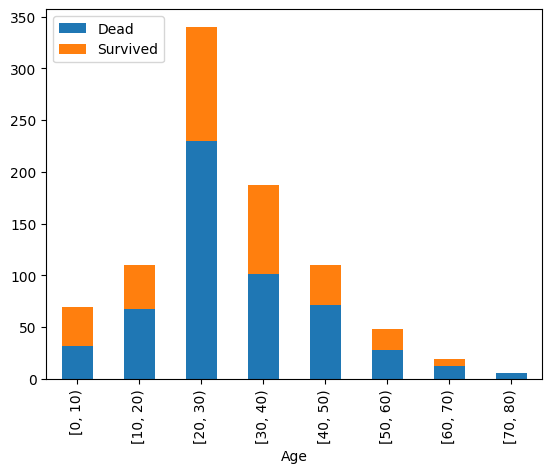

In [9]:
age_bins = pd.cut(data_train['Age'], bins=range(0, 90, 10), right=False)
data_train.groupby(age_bins)['Survived'].value_counts().unstack().plot(kind='bar', stacked=True)
plt.legend(['Dead', 'Survived'], loc='upper left')
plt.show()

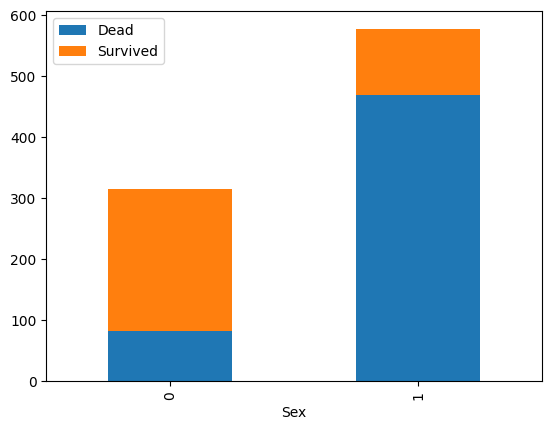

In [10]:
data_train.groupby(['Sex','Survived'])['Survived'].count().unstack().plot(kind='bar', stacked=True)
plt.legend(['Dead', 'Survived'], loc='upper left')
plt.show()

通过一系列属性分析，我们决定采用Pclass，Sex，Age三个属性来精选分类。

In [11]:
from sklearn.linear_model import LogisticRegression

features = ['Pclass', 'Sex', 'Age']
label = 'Survived'

lr_model = LogisticRegression()
lr_model.fit(data_train.loc[:,features],data_train.loc[:,label])

lr_pridict = lr_model.predict(data_test.loc[:,features])

ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values